In [246]:
!pip install music21
!pip install miditoolkit
!pip install miditok

In [247]:
import numpy as np
import pandas as pd
from io import open
import tensorflow as tf
import glob
import pickle
import os
import torch
import pathlib
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import copy
from pathlib import Path, PurePath, PurePosixPath
from music21 import converter, instrument, note, chord, stream
from miditok import CPWord, REMI
from miditok.utils import get_midi_programs
from miditoolkit import MidiFile

In [248]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [249]:
# Creates the tokenizer and list the file paths
remi_enc = REMI()  # uses defaults parameters
files_paths = list(Path(data_dir).glob('**/*.mid*'))
print(files_paths)

[PosixPath('data/maestro-v2.0.0/2013/ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_14_R1_2013_wav--4.midi'), PosixPath('data/maestro-v2.0.0/2013/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--1.midi'), PosixPath('data/maestro-v2.0.0/2013/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_04_R1_2013_wav--4.midi'), PosixPath('data/maestro-v2.0.0/2013/ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_17_R3_2013_wav--1.midi'), PosixPath('data/maestro-v2.0.0/2013/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_05_R1_2013_wav--3.midi'), PosixPath('data/maestro-v2.0.0/2013/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_08_R2_2013_wav--2.midi'), PosixPath('data/maestro-v2.0.0/2013/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_02_R1_2013_wav--2.midi'), PosixPath('data/maestro-v2.0.0/2013/ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--4.midi'), PosixPath('data/maestro-v2.0.0/2013/ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_14_R1_2013_wav--3.midi'), PosixPath('data/maestro-v2.0.0/2013/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_15_R2_2013_wav--2.midi'),

In [250]:
midi = MidiFile('data/maestro-v2.0.0/2017/MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--2.midi')
remi_enc.current_midi_metadata = {'time_division': midi.ticks_per_beat, 'tempo_changes': midi.tempo_changes}
print(midi)

ticks per beat: 480
max tick: 111564
tempo changes: 1
time sig: 1
key sig: 0
markers: 0
lyrics: False
instruments: 1


In [251]:
notes = []
n_notes = 0
remi_enc = REMI()

for f in files_paths:
    # read the MIDI file
    midi = MidiFile(f)

    # Converts MIDI to tokens
    tokens = remi_enc(midi)

    notes.append(tokens)
    n_notes += len(notes)
print("processed", n_notes, "notes")

<ipython-input-251-26ceb2544804>:10: UserWarning: You are using a depreciated `miditoolkit.MidiFile` object. MidiTokis now (>v3.0.0) using symusic.Score as MIDI backend. Your MIDI willbe converted on the fly, however please consider using symusic.
  tokens = remi_enc(midi)


processed 822403 notes


In [253]:
midi

ticks per beat: 384
max tick: 225188
tempo changes: 1
time sig: 1
key sig: 0
markers: 0
lyrics: False
instruments: 1

In [254]:
len(notes[0][0])

34706

In [255]:
notes = [note[0] for note in notes]

In [256]:
len(notes[0])

34706

In [257]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)

    def words(self):
        return self.idx2word


class Corpus(object):
    def __init__(self, notes, num):
        self.dictionary = Dictionary()
        self.train = self.tokenize(notes[:-num])
        self.valid = self.tokenize(notes[-num:])
#         self.test = self.tokenize(notes[-2:])

    def tokenize(self, notes):
        """Tokenizes a note sequence"""
        assert len(notes) > 0

        for song in notes:
            for note in song:
                self.dictionary.add_word(note)
                idss = []
        for song in notes:
            ids = []
            for note in song:
                ids.append(self.dictionary.word2idx[note])
        idss.append(torch.tensor(ids).type(torch.int64))
        ids = torch.cat(idss)


        return ids

In [258]:
corpus = Corpus(notes, 7)

In [259]:
len(notes[-10:])

10

In [260]:
corpus.valid.size(0)

6248

In [261]:
corpus.train.size(0)

14113

In [262]:
device = 'cpu'
def batchify(data, bsz):
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

eval_batch_size = 10
batch_size = 10
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, batch_size)
# test_data = batchify(corpus.test, batch_size)


In [263]:
train_data.shape

torch.Size([1411, 10])

In [264]:
class PositionalEncoding(nn.Module):
    """Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        # PE is the Positional Encoding matrix
        # THIS STORES THE POSITIONS OF THE SEQUENCE
        pe = torch.zeros(max_len, d_model)

        # Arange - RETURNS A RANGE BETWEEN VALUES, HERE IT IS 0 - max_len
        # unsqueeze - adds a dimension, 1 means that each element in the first list is now in a list
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # division term, here it is (10000 ** ((2 * i)/d_model))

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # calculating the position encoding for the even and odd terms
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Unsqueeze 0 will put PE in one list
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """
        # make embeddings relatively larger
        # This is so we do not lose the importance of the embedding
        x = x * math.sqrt(self.d_model)
        # we add the embedding to the PE
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [265]:
class MultiHeadAttention(nn.Module):
    """Parallel self attention given the number of heads and size
    .. math::
        X * Wk = K
        X * Wq = Q
        X * Wv = V
        \text{attention} = softmax(Q * transpose(K) / sqrt(d_model)) * V
    Args:
        d_model: the embed dim (default = 256).
        heads: number of heads (default = 4)
        max_length = max length of sequences (default = 2048)
        dropout: the dropout value (default = 0.1).
    Examples:
        >>> attention = MultiHeadAttention(d_model, heads)
    """
    def __init__(self, d_model = 256, heads = 4, max_length = 2048, dropout = 0.1):
        super().__init__()

        self.d = d_model
        self.h = heads
        self.dh = d_model // heads
        self.max_length = max_length
        self.E = torch.randn([heads, self.max_length, self.dh])

        self.q_linear = nn.Linear(self.dh, self.dh)
        self.v_linear = nn.Linear(self.dh, self.dh)
        self.k_linear = nn.Linear(self.dh, self.dh)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):

        batch_size = q.size(0)
        T = q.size(1)
        dh = q.size(2) // self.h

        k = k.view(batch_size, T, self.h, dh)
        q = q.view(batch_size, T, self.h, dh)
        v = v.view(batch_size, T, self.h, dh)
        # perform linear operation and split into h heads

        K = self.k_linear(k)
        Q = self.q_linear(q)
        V = self.v_linear(v)

        # transpose to get dimensions bs * h * sl * d_model

        K = K.transpose(1,2)
        Q = Q.transpose(1,2)
        V = V.transpose(1,2)

        #start index of position embedding

        embedding_start = self.max_length - T

        #apply same position embeddings across the batch

        Er  = self.E[:, embedding_start:, :].unsqueeze(0)

        QE = torch.matmul(Q, K.transpose(-2, -1))
        QE = self.mask_attention_positions(QE)

        #Get relative position attention scores
        #combine batch with head dimension
        SRel = self.skew_padding_position(QE)

#         Q = Q.contiguous().view(batch_size*self.h, T, self.dh)
#         K = K.contiguous().view(batch_size*self.h, T, self.dh)
#         V = V.contiguous().view(batch_size*self.h, T, self.dh)

        #Compute scaled dot-product self-attention
        #scale pre-matrix multiplication
        Q = Q / (q.size(2) ** (1/4))
        K = K / (q.size(2) ** (1/4))

        # calculate attention
        scores, weights = self.attention(QE, SRel, V, mask, self.dropout)

        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(batch_size, -1, self.d)

        output = self.out(concat)

        return output

    def attention(self, QE, Srel, V, mask=None, dropout=None):
        log = QE + Srel
        log = log / math.sqrt(self.dh)

        if mask is not None:
#             mask = mask.unsqueeze(1)
            log += (mask.to(torch.int64) * -1e9).to(log.dtype)

#             print(mask.shape)
#             log = log.masked_fill(mask == 0, float('-inf'))

        scores = F.softmax(log, -1)

        if dropout is not None:
            scores = dropout(scores)

#         print(scores.shape, V.shape)
        attention = torch.matmul(scores, V)

#         scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)

#         if mask is not None:
#             print(scores.shape)

#     #         mask = mask.unsqueeze(1)
#             print(mask.shape)
#     #         scores = scores.masked_fill(mask == 0, float('-inf'))
#         scores = F.softmax(scores, dim=-1)

#

#         output = torch.matmul(scores, v)
        return attention, scores

    def mask_attention_positions(self, qe):
        # to avoid looking backward by masking the positions
        index = qe.shape[-1]
        mask = torch.triu(torch.ones(index, index), 1).flip(1)
        return qe.masked_fill((mask == 1), 0)

    def skew_padding_position(self, qe):
        # to add padding to the skewed result after masking the matrix
        # column of zeros on left
        padded_qe = F.pad(qe, [1,0])
        s = padded_qe.shape
        padded_qe = padded_qe.view(s[0], s[1], s[3], s[2])
        #take out first (padded) row
        return padded_qe[:,:,1:,:]

In [266]:
class FeedForward(nn.Module):
#     def __init__(self, d_model, d_ff=2048, dropout = 0.1):
#         super().__init__()
#         # We set d_ff as a default to 2048
#         self.linear_1 = nn.Linear(d_model, d_ff)
#         self.dropout = nn.Dropout(dropout)
#         self.linear_2 = nn.Linear(d_ff, d_model)
#     def forward(self, x):
#         x = self.dropout(F.relu(self.linear_1(x)))
#         x = self.linear_2(x)
#         return x
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.linear_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear_2(self.dropout(F.relu(self.linear_1(x))))


In [267]:
# build an encoder layer with one multi-head attention layer and one # feed-forward layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)

        self.attn = MultiHeadAttention(d_model, heads)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        self.norm_3 = nn.LayerNorm(d_model)

        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)

        self.attn_1 = MultiHeadAttention(d_model, heads)
        self.attn_2 = MultiHeadAttention(d_model, heads)
        self.ff = FeedForward(d_model)
    def forward(self, x, memory, mask = None):
#         x2 = self.norm_1(x)
#         x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
#         x2 = self.norm_2(x)
#         x = x + self.dropout_2(self.attn_2(x2, x2, x2,
#         src_mask))
#         x2 = self.norm_3(x)
#         x = x + self.dropout_3(self.ff(x2))

        #perform masked attention on input
        #masked so queries cannot attend to subsequent keys
        #Pass through sublayers of attention and feedforward.
        #Apply dropout to sublayer output, add it to input, and norm.
        attn = self.attn_1(x, x, x, mask)
        x = x + self.dropout_1(attn)
        x = self.norm_1(x)
        x = x + self.dropout_2(self.attn_2(x, memory, memory, mask))
        ff = self.ff(x)
        x = x + self.dropout_2(ff)
        x = self.norm_2(x)

        return x
#         return x
# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [268]:
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super().__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), self.N)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, src, mask):
        x = self.layers[0](src, mask)
        for i in range(1,self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, src, trg, src_mask = None):
        x = self.layers[0](src, trg, src_mask)
        for i in range(1,self.N):
            x = self.layers[i](x, trg, src_mask)
        return self.norm(x)

In [269]:
class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, ntoken, d_model, nhead, nhid, nlayers, dropout=0.5, max_length = 2048):
        super(TransformerModel, self).__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
        except:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
        self.model_type = 'Transformer'
        # original mask
        self.src_mask = None
        self.max_length = max_length
        self.d_model = d_model

        # embedding encoding
        self.embedding = nn.Embedding(ntoken, d_model)

        # positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # encoder
        encoder_layers = TransformerEncoderLayer(d_model, nhead, nhid, dropout)
        self.encoder = TransformerEncoder(encoder_layers, nlayers)

#         self.decoder = nn.Linear(d_model, ntoken)



#         self.encoder = Encoder(d_model, nlayers, nhead)
#         self.encoder.eval()
        # decoder
        decoder_layers = TransformerDecoderLayer(d_model, nhead, nhid, dropout)
        self.decoder = TransformerDecoder(decoder_layers, nlayers)
#         self.decoder = Decoder(ntoken, d_model, nlayers, nhead)
#         self.decoder.eval()
        # classification layer
        self.classification_layer = nn.Linear(d_model, ntoken)

        self.init_weights()
    def _generate_square_subsequent_mask(self, sz):

        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
#         mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#         mask = utils.get_masked_with_pad_tensor(self.max_length, x, x, config.pad_token)
        return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.embedding.weight, -initrange, initrange)
        self.classification_layer.bias.data.zero_()
        self.classification_layer.weight.data.uniform_(-initrange, initrange)
#         nn.init.zeros_(self.decoder.weight)
#         nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, src_mask):

        if src_mask == None:
            src_mask = self._generate_square_subsequent_mask(len(src))
        self.src_mask = src_mask

        src = self.pos_encoder(self.embedding(src))
        output = self.encoder(src, self.src_mask)
        output = self.decoder(output, src)

        #Flatten:
#         shape = output.shape
#         tensor_reshaped = output.reshape(shape[0],-1)
#         #Drop all rows containing any nan:
#         tensor_reshaped = tensor_reshaped[~torch.any(tensor_reshaped.isnan(),dim=1)]
#         #Reshape back:
#         output = tensor_reshaped.reshape(tensor_reshaped.shape[0],*shape[1:])
#         print(output)
        output = self.classification_layer(output)
#         print(output)
        return F.log_softmax(output, dim=-1)


In [270]:
len(corpus.dictionary)

217

In [271]:
ntokens = len(corpus.dictionary)
emsize = 200
nhead = 2
nhid = 200
nlayer = 2
dropout = 0.2
# Loop over epochs.
lr = 0.005
best_val_loss = None
epochs = 200
save = './model.pt'
criterion = nn.CrossEntropyLoss()

In [272]:
final_losses = []
emsizes = []
nheads = []
nhids = []
nlayers = []

for em in emsizes:
    for head in nhead:
        for hid in nhid:
            for layer in nlayer:
                emsizes.append(em)
                nheads.append(head)
                nhids.append(hid)
                nlayers.append(layer)
                best_val_loss = None

                model = TransformerModel(ntokens, em, head, hid, layer, dropout).to(device)

                # At any point you can hit Ctrl + C to break out of training early.
                try:
                    for epoch in range(1, epochs+1):
                        epoch_start_time = time.time()
                        train()
                        val_loss = evaluate(test_data)
                        train_loss = evaluate(train_data)
                        print('-' * 89)
                        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | train loss {:5.2f}'
                                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                                           val_loss, train_loss, math.exp(val_loss)))
                        print('-' * 89)
                        # Save the model if the validation loss is the best we've seen so far.
                        if not best_val_loss or val_loss < best_val_loss:
                            with open(save, 'wb') as f:
                                torch.save(model, f)
                            best_val_loss = val_loss
                        else:
                            # Anneal the learning rate if no improvement has been seen in the validation dataset.
                            lr /= 2.0
                except KeyboardInterrupt:
                    print('-' * 89)
                    print('Exiting from training early')
                final_losses.append(best_val_loss)

In [273]:
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayer, dropout).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [274]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""

    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [275]:
# get_batch subdivides the source data into chunks of length args.bptt.
# If source is equal to the example output of the batchify function, with
# a bptt-limit of 2, we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the batchify function. The chunks are along dimension 0, corresponding
# to the seq_len dimension in the LSTM.
seq_length = 35
def get_batch(source, i):
    seq_len = min(seq_length, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [276]:
def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [277]:
def evaluate(model, eval_data):
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(seq_length).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, seq_length):
            data, targets = get_batch(eval_data, i)
            batch_size = data.size(0)
            if batch_size != seq_length:
                src_mask = src_mask[:batch_size, :batch_size]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

In [278]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model):
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(seq_length).to(device)

    num_batches = len(train_data) // seq_length
    for batch, i in enumerate(range(0, train_data.size(0) - 1, seq_length)):
        data, targets = get_batch(train_data, i)
        batch_size = data.size(0)
        if batch_size != seq_length:  # only on last batch
            src_mask = src_mask[:batch_size, :batch_size]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  2.90s | valid loss  5.45 | train loss  5.42 | valid ppl   233.43
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  2.37s | valid loss  5.35 | train loss  5.26 | valid ppl   210.76
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  2.45s | valid loss  5.27 | train loss  5.14 | valid ppl   194.83
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time:  2.37s | valid loss  5.21 | train loss  5.04 | valid ppl   183.4

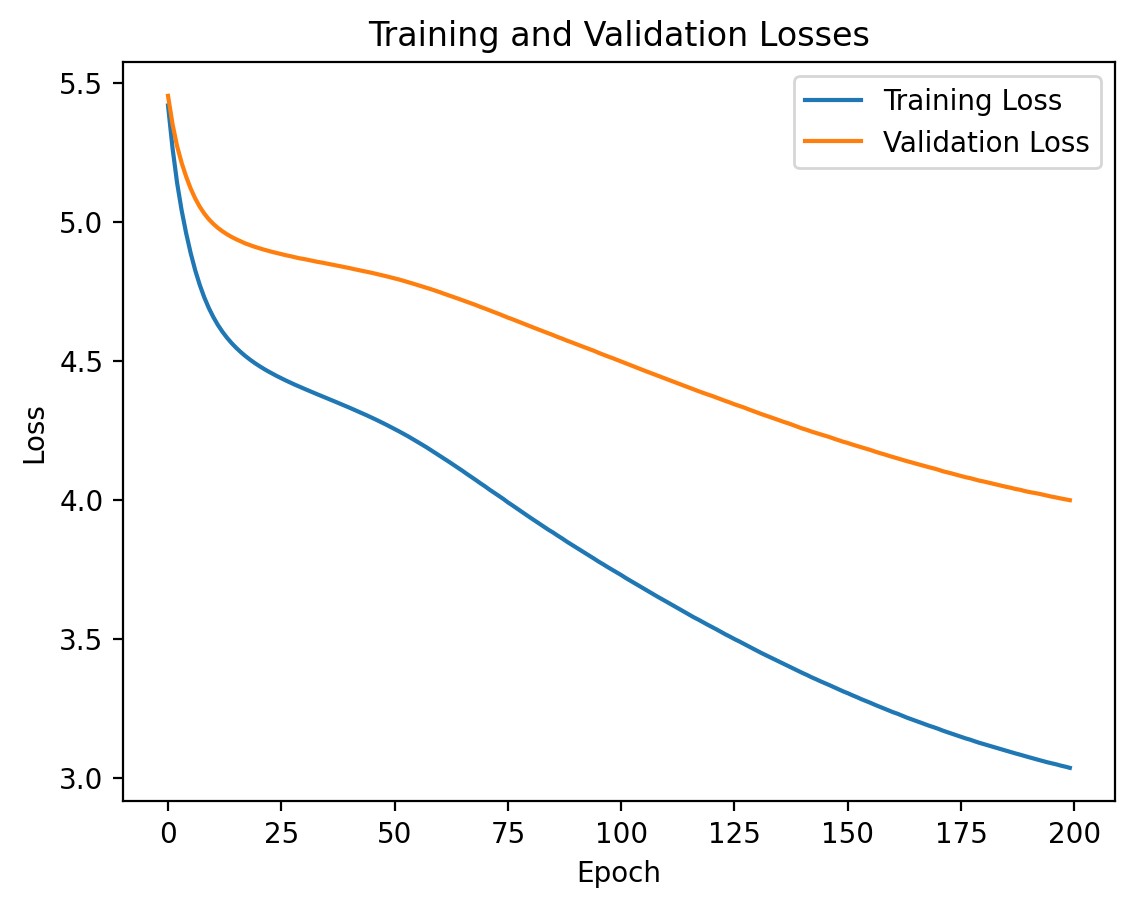

In [279]:
import matplotlib.pyplot as plt
import time
import math

train_losses = []
val_losses = []

try:
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        train(model)
        val_loss = evaluate(model, val_data)
        val_losses.append(val_loss)
        train_loss = evaluate(model, train_data)
        train_losses.append(train_loss)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | train loss {:5.2f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, train_loss, math.exp(val_loss)))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(save, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 2.0

        # Plot the training and validation losses
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')


In [280]:
n_generate = 2000
temperature = 1
sequence = []
log_interval = 50 # interval between logs

In [281]:
model.eval()

input = torch.randint(ntokens, (1, 1), dtype=torch.long).to(device)
src_mask = generate_square_subsequent_mask(len(input)).to(device)
with open('./output', 'w') as outf:
    with torch.no_grad():  # no tracking history
        for i in range(n_generate):
            src_mask = generate_square_subsequent_mask(len(input)).to(device)
            output = model(input, src_mask)
            word_weights = output[-1].squeeze().div(temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            word_tensor = torch.Tensor([[word_idx]]).long().to(device)
            input = torch.cat([input, word_tensor], 0)


            word = corpus.dictionary.idx2word[word_idx]

            outf.write(str(word) + ('\n' if i % 20 == 19 else ' '))

            sequence.append(word)

            if i % log_interval == 0:
                print('| Generated {}/{} notes'.format(i, n_generate))

| Generated 0/2000 notes
| Generated 50/2000 notes
| Generated 100/2000 notes
| Generated 150/2000 notes
| Generated 200/2000 notes
| Generated 250/2000 notes
| Generated 300/2000 notes
| Generated 350/2000 notes
| Generated 400/2000 notes
| Generated 450/2000 notes
| Generated 500/2000 notes
| Generated 550/2000 notes
| Generated 600/2000 notes
| Generated 650/2000 notes
| Generated 700/2000 notes
| Generated 750/2000 notes
| Generated 800/2000 notes
| Generated 850/2000 notes
| Generated 900/2000 notes
| Generated 950/2000 notes
| Generated 1000/2000 notes
| Generated 1050/2000 notes
| Generated 1100/2000 notes
| Generated 1150/2000 notes
| Generated 1200/2000 notes
| Generated 1250/2000 notes
| Generated 1300/2000 notes
| Generated 1350/2000 notes
| Generated 1400/2000 notes
| Generated 1450/2000 notes
| Generated 1500/2000 notes
| Generated 1550/2000 notes
| Generated 1600/2000 notes
| Generated 1650/2000 notes
| Generated 1700/2000 notes
| Generated 1750/2000 notes
| Generated 180

In [282]:
sequence = [sequence]

In [283]:
remi_enc = REMI()

In [284]:
converted_back_midi = remi_enc.tokens_to_midi(sequence)

In [285]:
converted_back_midi.dump_midi('generated_data.mid')

In [286]:
!pip install pretty_midi

In [287]:
import pretty_midi

In [310]:
sample_file = 'data/maestro-v2.0.0/2017/MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--2.midi'  # You can also put filenames[index]
generated_file = "generated_data.mid"

In [311]:
pm = pretty_midi.PrettyMIDI(generated_file)
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [312]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=74, note_name=D5, duration=0.2500
1: pitch=74, note_name=D5, duration=0.2500
2: pitch=43, note_name=G2, duration=0.2500
3: pitch=76, note_name=E5, duration=0.3125
4: pitch=69, note_name=A4, duration=0.3750
5: pitch=59, note_name=B3, duration=0.2500
6: pitch=61, note_name=C#4, duration=0.1875
7: pitch=74, note_name=D5, duration=0.0625
8: pitch=24, note_name=C1, duration=0.3125
9: pitch=73, note_name=C#5, duration=0.6250


In [313]:
import collections
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file) #initializes a PrettyMIDI object (pm) using the provided MIDI file.
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name : np.array(value) for name, value in notes.items()})

In [314]:
generated_notes = midi_to_notes(generated_file)
sample_notes = midi_to_notes(sample_file)
generated_notes.head()

,pitch,start,end,step,duration
0,74,0.0000,0.25,0.0000,0.2500
1,74,0.0000,0.25,0.0000,0.2500
2,43,0.0000,0.25,0.0000,0.2500
3,76,1.4375,1.75,1.4375,0.3125
4,69,1.6250,2.00,0.1875,0.3750


In [315]:
from typing import Dict, List, Optional, Sequence, Tuple
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

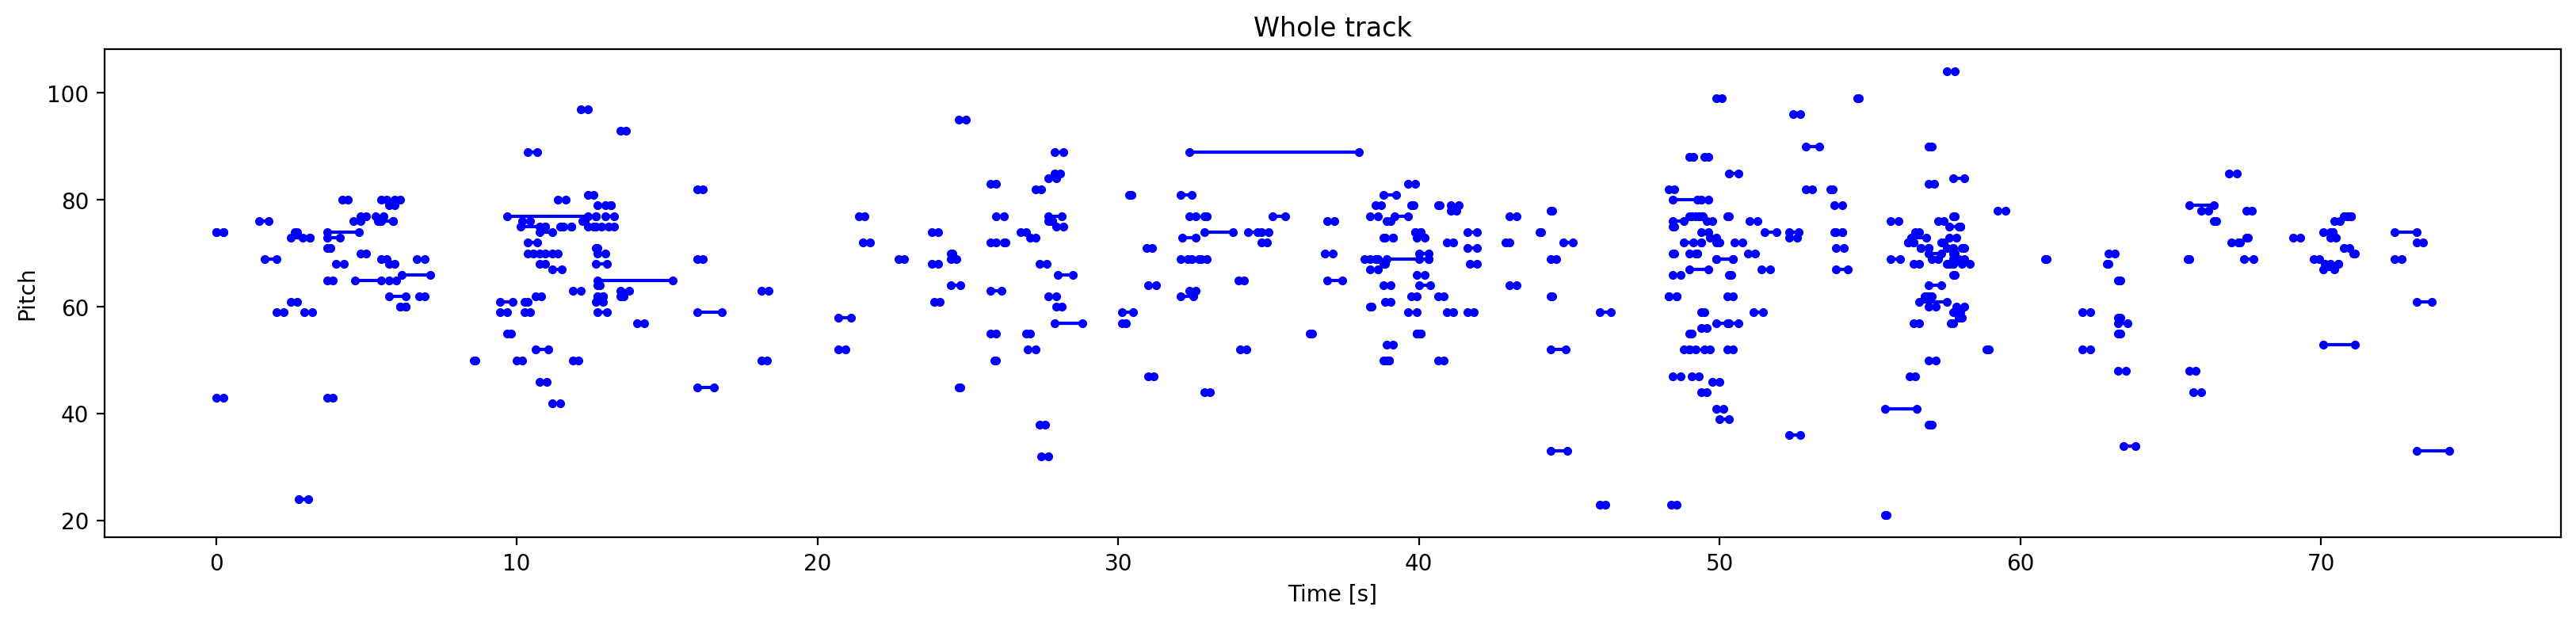

In [316]:
plot_piano_roll(generated_notes)

In [317]:
import seaborn as sns
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

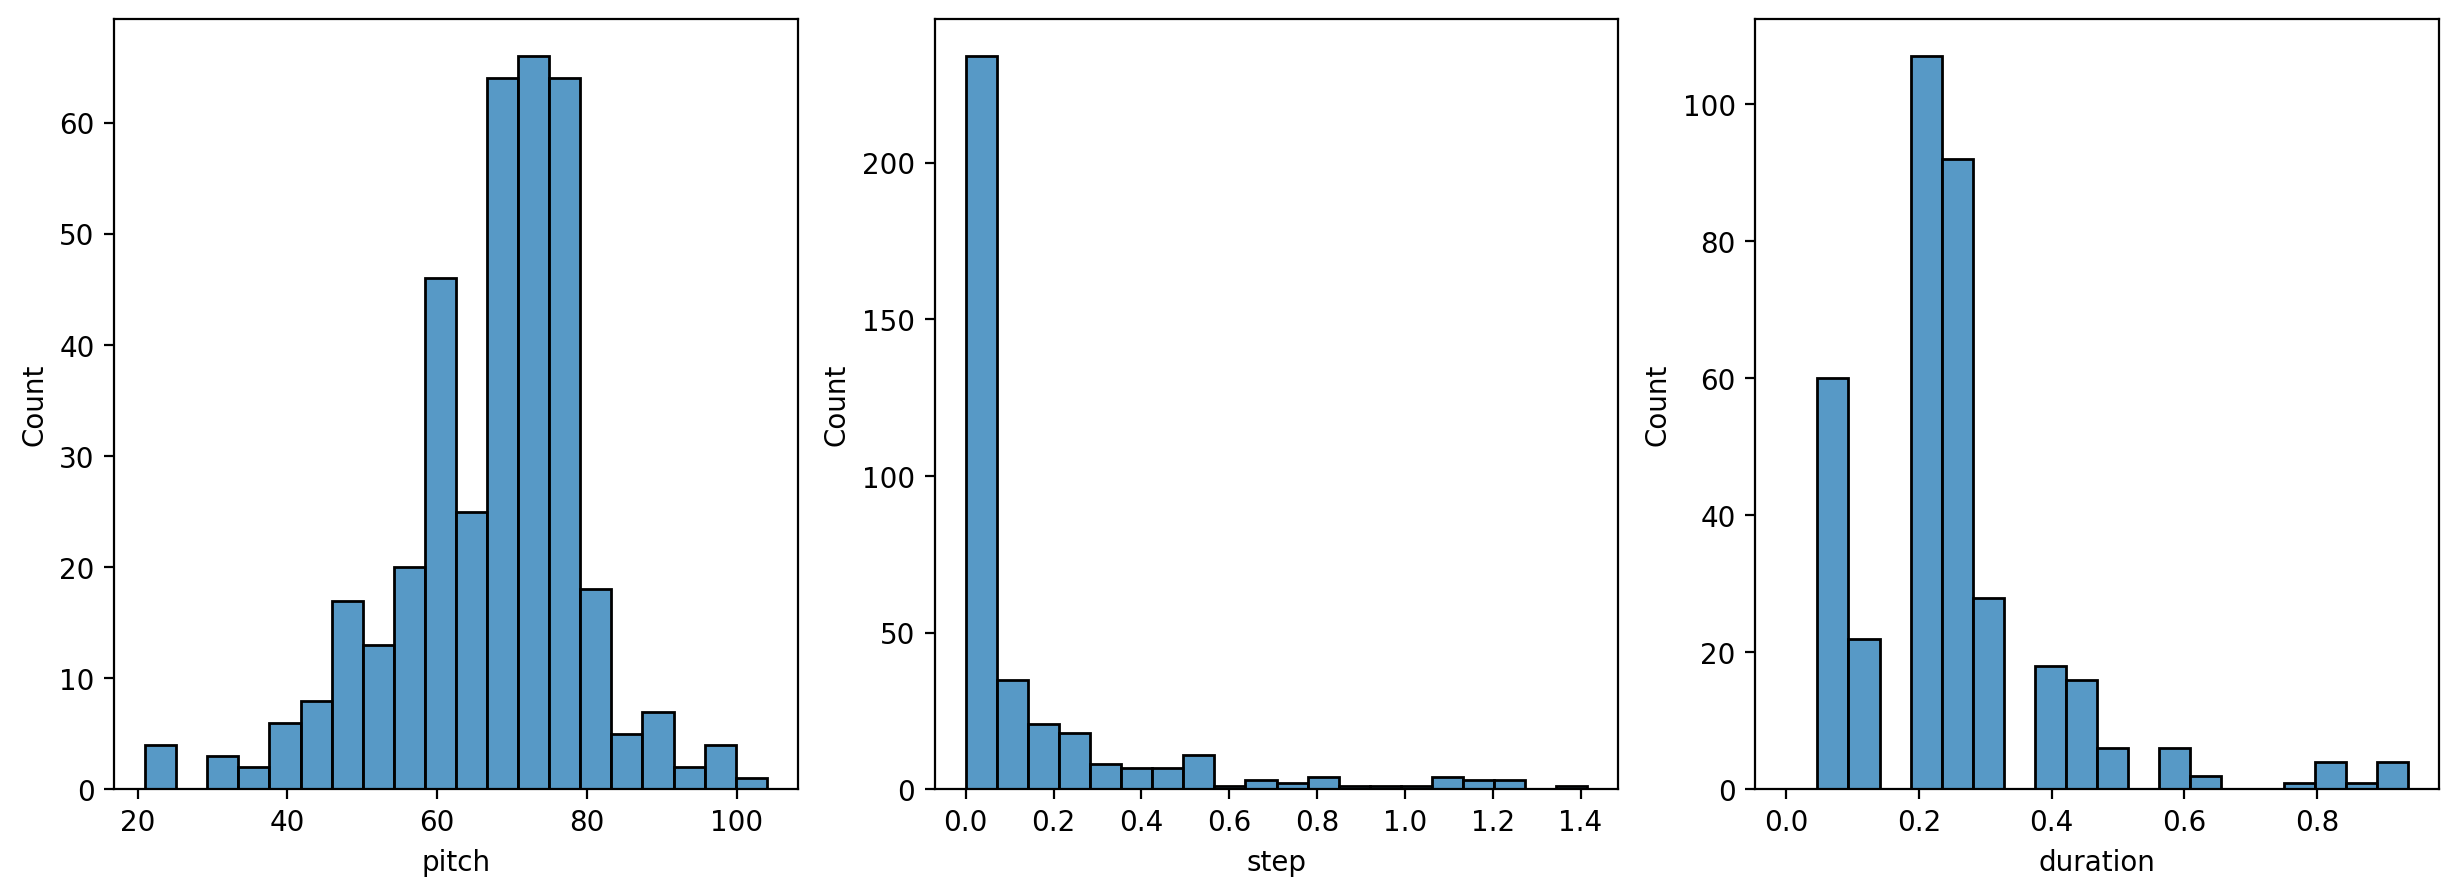

In [318]:
plot_distributions(generated_notes)

In [319]:
import music21

def extract_notes(midi_file):
    # Parse the MIDI file and extract notes
    midi_stream = music21.converter.parse(midi_file)
    notes = []
    for element in midi_stream.flat.notesAndRests:
        # Check if the element is a chord
        if isinstance(element, music21.chord.Chord):
            # Extract pitches of individual notes in the chord
            for note in element:
                note_features = {
                    'pitch': note.pitch.ps,  # Convert pitch to MIDI pitch value
                    'duration': element.duration.quarterLength  # Duration in quarter note units
                    # Add other relevant features as needed
                }
                notes.append(note_features)
        elif isinstance(element, music21.note.Note):
            # Extract relevant features of the note
            note_features = {
                'pitch': element.pitch.ps,  # Convert pitch to MIDI pitch value
                'duration': element.duration.quarterLength  # Duration in quarter note units
                # Add other relevant features as needed
            }
            notes.append(note_features)
    return notes

def calculate_mse(sample_notes, extracted_notes):
    # Ensure sequences have the same length
    min_length = min(len(sample_notes), len(extracted_notes))
    sample_notes = sample_notes[:min_length]
    extracted_notes = extracted_notes[:min_length]

    # Compute squared differences
    squared_diffs = [
        (sample_note['pitch'] - extracted_note['pitch']) ** 2 +
        (sample_note['duration'] - extracted_note['duration']) ** 2
        # Add squared differences for other features as needed
        for sample_note, extracted_note in zip(sample_notes, extracted_notes)
    ]

    # Compute mean squared error
    mse = sum(squared_diffs) / len(squared_diffs)

    return mse

sample_notes = extract_notes(sample_file)
extracted_notes = extract_notes(generated_file)

mse = calculate_mse(sample_notes, extracted_notes)
print("Mean Squared Error:", mse)


/usr/local/lib/python3.10/dist-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Mean Squared Error: 495.5994775441327
